Pull Data from FRED and other sources

This notebook is a playground for creating and testing different kinds of models to forecast US Dollar Inflation.  The vast majority of the data I use is extracted from the St. Louis Federal Reserve's FRED API, and some of the stock market data and data on gold prices are from the Wall Street Journal.  This project uses the same data that a different, but related project of mine has already extracted, so the code is copied at the bottom to be re-used for this notebook specifically.

In no particular order, the models that I will build include:
- Various types of linear and non-linear regression, scaling, splitting, and manipulating the data in different ways
- Support Vector Machine
- Random Forest
- Neural Network
- Binning data (understanding the dangers of doing so manually) and using association rule mining
- Creation of models by economic sector using a mix of techniques, and combining them to create an ensemble model 

My ultimate goals are to create precise models using existing techniques, and also to create my own inflation model by combining techniques or by implementing an idea I have to create a model based on vectors (different from SVM).  I will test the performance of all models, and highlight those that perform the best.

In [1]:
# Import Dependencies and API Key

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import os
import json

# Import API key. Git ignore to be used in the future to hide FRED API key, but isn't utilized yet
from api_keys import fred_key

In [20]:
from tensorflow import keras

In [23]:
from sklearn.linear_model import LinearRegression

Model 1: 

In [30]:
m1m2_df

,m1,m1_change,m1_pct_change,m2,m2_change,m2_pct_change,non_m1_components_m2,non_m1_components_m2_change,non_m1_components_m2_pct_change
Date,,,,,,,,,
1959-01-01,138.9,0,0,286.6,0,0,NaN,NaN,NaN
1959-02-01,139.4,0.5,0.359971,287.7,1.1,0.38381,NaN,NaN,NaN
1959-03-01,139.7,0.3,0.215208,289.2,1.5,0.521376,NaN,NaN,NaN
1959-04-01,139.7,0,0,290.1,0.9,0.311203,NaN,NaN,NaN
1959-05-01,140.7,1,0.71582,292.2,2.1,0.723888,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-04-01,18915.7,246.3,1.31927,20122.7,209.2,1.05054,NaN,NaN,NaN
2021-05-01,19192.9,277.2,1.46545,20372.4,249.7,1.24089,NaN,NaN,NaN
2021-06-01,19238.2,45.3,0.236025,20387.4,15,0.073629,NaN,NaN,NaN


In [36]:
m1m2_df.tail(30)

,m1,m1_change,m1_pct_change,m2,m2_change,m2_pct_change,non_m1_components_m2,non_m1_components_m2_change,non_m1_components_m2_pct_change
Date,,,,,,,,,
2020-09-21,NaN,NaN,NaN,NaN,NaN,NaN,1438.9,-8.8,-0.607861
2020-09-28,NaN,NaN,NaN,NaN,NaN,NaN,1426.1,-12.8,-0.889568
2020-10-01,17346.8,190,1.10743,18747.9,146.3,0.786491,NaN,NaN,NaN
2020-10-05,NaN,NaN,NaN,NaN,NaN,NaN,1415.4,-10.7,-0.750298
2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN,1406.2,-9.2,-0.649993
2020-10-19,NaN,NaN,NaN,NaN,NaN,NaN,1401.5,-4.7,-0.334234
2020-10-26,NaN,NaN,NaN,NaN,NaN,NaN,1393.7,-7.8,-0.556547
2020-11-01,17589.1,242.3,1.3968,18958.7,210.8,1.12439,NaN,NaN,NaN
2020-11-02,NaN,NaN,NaN,NaN,NaN,NaN,1389.3,-4.4,-0.315706


In [47]:
pre_pandemic_m1m2_df = m1m2_df.reset_index()
pre_pandemic_m1m2_df = pre_pandemic_m1m2_df.loc[pre_pandemic_m1m2_df['Date']>='1971-09-01',:]
pre_pandemic_m1m2_df = pre_pandemic_m1m2_df.loc[pre_pandemic_m1m2_df['Date']<='2020-02-01',:]
pre_pandemic_m1m2_df

,Date,m1,m1_change,m1_pct_change,m2,m2_change,m2_pct_change,non_m1_components_m2,non_m1_components_m2_change,non_m1_components_m2_pct_change
152,1971-09-01,226.5,0.9,0.398936,692.5,7,1.02115,NaN,NaN,NaN
153,1971-10-01,227.2,0.7,0.309051,698.4,5.9,0.851986,NaN,NaN,NaN
154,1971-11-01,227.8,0.6,0.264085,704.6,6.2,0.887743,NaN,NaN,NaN
155,1971-12-01,228.3,0.5,0.219491,710.3,5.7,0.80897,NaN,NaN,NaN
156,1972-01-01,230.1,1.8,0.788436,717.7,7.4,1.04181,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3005,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,11399.8,20.9,0.183673
3006,2020-01-13,NaN,NaN,NaN,NaN,NaN,NaN,11434.2,34.4,0.30176
3007,2020-01-20,NaN,NaN,NaN,NaN,NaN,NaN,11456.5,22.3,0.195029
3008,2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,11493.6,37.1,0.323834


<AxesSubplot:>

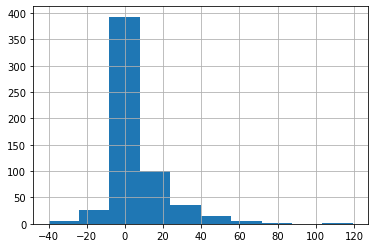

In [48]:
pre_pandemic_m1m2_df['m1_change'].hist()

In [49]:
from sklearn.preprocessing import StandardScaler
m1_change_array = pre_pandemic_m1m2_df['m1_change'].values.reshape(-1,1)
pre_pandemic_m1m2_df['m1_change_scaled']= StandardScaler().fit_transform(m1_change_array)
pre_pandemic_m1m2_df

,Date,m1,m1_change,m1_pct_change,m2,m2_change,m2_pct_change,non_m1_components_m2,non_m1_components_m2_change,non_m1_components_m2_pct_change,m1_change_scaled
152,1971-09-01,226.5,0.9,0.398936,692.5,7,1.02115,NaN,NaN,NaN,-0.386106
153,1971-10-01,227.2,0.7,0.309051,698.4,5.9,0.851986,NaN,NaN,NaN,-0.399813
154,1971-11-01,227.8,0.6,0.264085,704.6,6.2,0.887743,NaN,NaN,NaN,-0.406666
155,1971-12-01,228.3,0.5,0.219491,710.3,5.7,0.80897,NaN,NaN,NaN,-0.413519
156,1972-01-01,230.1,1.8,0.788436,717.7,7.4,1.04181,NaN,NaN,NaN,-0.324428
...,...,...,...,...,...,...,...,...,...,...,...
3005,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,11399.8,20.9,0.183673,NaN
3006,2020-01-13,NaN,NaN,NaN,NaN,NaN,NaN,11434.2,34.4,0.30176,NaN
3007,2020-01-20,NaN,NaN,NaN,NaN,NaN,NaN,11456.5,22.3,0.195029,NaN
3008,2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,11493.6,37.1,0.323834,NaN


<AxesSubplot:>

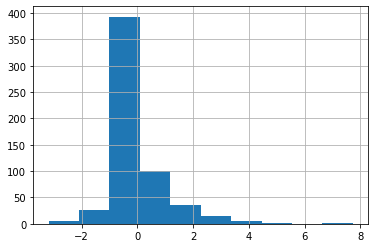

In [50]:
pre_pandemic_m1m2_df['m1_change_scaled'].hist()

In [123]:
m2_df = m1m2_df[['m2','m2_change','m2_pct_change']].reset_index()
government_expenditures_df = government_quarterly_df[['government_expenditures','government_expenditures_change','government_expenditures_pct_change']].reset_index()
net_exports_df = foreign_trade_month_quarter_df[['net_exports','net_exports_change','net_exports_pct_change']].reset_index()
inflation_expectation_df = cpi_monthly_df[['inflation_expectation','inflation_expectation_change','inflation_expectation_pct_change']].reset_index()
gdp_df = gdp_quarterly_df[['gdp','gdp_change','gdp_pct_change']].reset_index()
reserve_balances_df = banks_week_month_df[['reserve_balances','reserve_balances_change','reserve_balances_pct_change']].reset_index()
unemployment_df = consumer_monthly_df[['unemployment','unemployment_change','unemployment_pct_change']].reset_index()
real_output_hour_df = consumers_quarterly_df[['real_output_hour','real_output_hour_change','real_output_hour_pct_change']].reset_index()
ppi_all_commodities_df = ppi_monthly_df[['ppi_all_commodities','ppi_all_commodities_change','ppi_all_commodities_pct_change']].reset_index()
cpi_df = cpi_monthly_df[['cpi','cpi_change','cpi_pct_change']].reset_index()
basic_neural_predictor_df_list = [government_expenditures_df,net_exports_df,inflation_expectation_df,gdp_df,reserve_balances_df,\
                                 unemployment_df,real_output_hour_df,ppi_all_commodities_df,cpi_df]

In [124]:
basic_neural_all_df = m2_df
for each_df in basic_neural_predictor_df_list:
    basic_neural_all_df = basic_neural_all_df.merge(each_df, how="inner", on="Date")

In [131]:
# basic_neural_all_df = basic_neural_all_df.set_index("Date")
basic_neural_all_df = basic_neural_all_df.loc[basic_neural_all_df['Date']<='2020-02-01',:]
basic_neural_all_df = basic_neural_all_df.loc[basic_neural_all_df['Date']>='1971-09-01',:]
basic_neural_all_df = basic_neural_all_df.reset_index()
basic_neural_all_df

,index,Date,m2,m2_change,m2_pct_change,government_expenditures,government_expenditures_change,government_expenditures_pct_change,net_exports,net_exports_change,...,unemployment_pct_change,real_output_hour,real_output_hour_change,real_output_hour_pct_change,ppi_all_commodities,ppi_all_commodities_change,ppi_all_commodities_pct_change,cpi,cpi_change,cpi_pct_change
0,51,1971-10-01,698.4,5.9,0.851986,383.306,6.174,1.63709,-1.92,-2.156,...,-3.33333,45.079,-0.397,-0.872988,38.3,0,0,40.9,0.1,0.245098
1,52,1972-01-01,717.7,7.4,1.04181,399.428,16.122,4.20604,-3.534,-1.614,...,-3.33333,45.785,0.706,1.56614,38.8,0.2,0.518135,41.2,0.1,0.243309
2,53,1972-04-01,738.4,4.9,0.66803,403.929,4.501,1.12686,-4.258,-0.724,...,-1.72414,46.69,0.905,1.97663,39.3,0.1,0.255102,41.5,0.1,0.241546
3,54,1972-07-01,759.5,9.8,1.30719,404.908,0.979,0.242369,-2.638,1.62,...,-1.75439,46.961,0.271,0.580424,40,0.3,0.755668,41.8,0.1,0.239808
4,55,1972-10-01,786.9,8.6,1.10497,419.285,14.377,3.55068,-3.061,-0.423,...,1.81818,47.363,0.402,0.856029,40.1,-0.1,-0.248756,42.2,0.1,0.23753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,240,2019-01-01,14443.3,69.4,0.48282,7165.64,116.589,1.65397,-606.4,34.52,...,2.5641,106.717,0.894,0.844807,199.1,-1.9,-0.945274,252.441,-0.052,-0.0205946
190,241,2019-04-01,14568.9,35.4,0.243575,7243.44,77.8,1.08574,-632.287,-25.887,...,-2.63158,107.846,1.129,1.05794,202.1,1.3,0.64741,255.326,1.179,0.463905
191,242,2019-07-01,14857.9,70.9,0.479475,7319.77,76.329,1.05377,-613.975,18.312,...,0,108.056,0.21,0.194722,200.7,0.4,0.1997,255.925,0.502,0.196537
192,243,2019-10-01,15153.1,126.5,0.84184,7418.35,98.588,1.34687,-532.389,81.586,...,2.85714,108.212,0.156,0.14437,198.6,0.2,0.100806,257.387,0.855,0.333292


In [136]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame)
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [137]:
new_basic_neural_all = clean_dataset(basic_neural_all_df)
new_basic_neural_all

ValueError: could not convert string to float: '1978-01-01'

In [126]:
basic_neural_all_df.tail(40)

,Date,m2,m2_change,m2_pct_change,government_expenditures,government_expenditures_change,government_expenditures_pct_change,net_exports,net_exports_change,net_exports_pct_change,...,unemployment_pct_change,real_output_hour,real_output_hour_change,real_output_hour_pct_change,ppi_all_commodities,ppi_all_commodities_change,ppi_all_commodities_pct_change,cpi,cpi_change,cpi_pct_change
205,2010-04-01,8532.8,30.6,0.359907,5872.57,67.594,1.16442,-542.514,-33.322,-6.54409,...,0,98.613,0.154,0.15641,184.4,1.1,0.600109,217.403,0.05,0.0230041
206,2010-07-01,8616.3,9.6,0.111541,5825.41,-47.154,-0.802954,-553.943,-11.429,-2.10667,...,0,99.153,0.54,0.547595,184.1,0.6,0.326975,217.605,0.406,0.186925
207,2010-10-01,8746.9,49.1,0.564511,5834.79,9.379,0.161001,-523.586,30.357,5.48017,...,-1.05263,99.568,0.415,0.418545,186.6,1.7,0.919416,219.035,0.76,0.348185
208,2011-01-01,8820.4,21,0.238653,5848,13.211,0.226418,-568.476,-44.89,-8.57357,...,-2.15054,98.894,-0.674,-0.676924,192.7,3,1.58144,221.187,0.715,0.324304
209,2011-04-01,9002.1,61.5,0.687873,5906.47,58.463,0.999709,-581.092,-12.616,-2.21927,...,1.11111,99.012,0.118,0.11932,203.1,3.9,1.95783,224.093,1.047,0.46941
210,2011-07-01,9313.8,165.4,1.80797,5852.87,-53.601,-0.907497,-567.111,13.981,2.40599,...,-1.0989,98.693,-0.319,-0.322183,204.6,0.7,0.343306,225.395,0.589,0.262004
211,2011-10-01,9559.5,33.7,0.353776,5879.57,26.708,0.456323,-601.788,-34.677,-6.11468,...,-2.22222,99.374,0.681,0.690019,201.1,-2.6,-1.27639,226.75,0.153,0.0675208
212,2012-01-01,9731.5,73.8,0.764157,5835.74,-43.837,-0.745581,-602.271,-0.483,-0.0802608,...,-2.35294,99.824,0.45,0.452835,200.7,0.9,0.45045,227.842,0.619,0.27242
213,2012-04-01,9889.9,52.8,0.536744,5825.19,-10.546,-0.180714,-565.241,37.03,6.14839,...,0,100.235,0.411,0.411725,203.7,-0.5,-0.244858,229.187,0.38,0.166079
214,2012-07-01,10055.3,57.2,0.572109,5834.16,8.97,0.153986,-523.083,42.158,7.45841,...,0,100.135,-0.1,-0.0997656,200.1,0.3,0.15015,228.59,0.066,0.028881


In [113]:
column_list_basic_neural = list(basic_neural_all_df)
for each_column in column_list_basic_neural:
    print('The max of ', each_column, round(basic_neural_all_df[each_column].max(),3))
    print('The min of ',each_column,round(basic_neural_all_df[each_column].min(),3))

The max of  m2 15406.8
The min of  m2 698.4
The max of  m2_change 165.4
The min of  m2_change -37.7
The max of  m2_pct_change 2.807
The min of  m2_pct_change -0.444
The max of  government_expenditures 7470.751
The min of  government_expenditures 383.306
The max of  government_expenditures_change 374.799
The min of  government_expenditures_change -130.538
The max of  government_expenditures_pct_change 7.508
The min of  government_expenditures_pct_change -2.848
The max of  net_exports 21.582
The min of  net_exports -823.284
The max of  net_exports_change 207.482
The min of  net_exports_change -84.172
The max of  net_exports_pct_change 49842.424
The min of  net_exports_pct_change -913.559
The max of  inflation_expectation 10.4
The min of  inflation_expectation 1.0
The max of  inflation_expectation_change 1.6
The min of  inflation_expectation_change -1.8
The max of  inflation_expectation_pct_change 88.889
The min of  inflation_expectation_pct_change -64.286
The max of  gdp 21694.458
The mi

In [88]:
cpi_df = cpi_monthly_df[['cpi','cpi_change','cpi_pct_change']]
cpi_df = cpi_df.reset_index()
cpi_df = cpi_df.loc[cpi_df['Date']<='2020-02-01',:]
cpi_df = cpi_df.loc[cpi_df['Date']>='1971-09-01',:]
cpi_df = cpi_df.set_index('Date')
cpi_df

,cpi,cpi_change,cpi_pct_change
Date,,,
1971-09-01,40.8,0.1,0.2457
1971-10-01,40.9,0.1,0.245098
1971-11-01,41,0.1,0.244499
1971-12-01,41.1,0.1,0.243902
1972-01-01,41.2,0.1,0.243309
...,...,...,...
2019-10-01,257.387,0.855,0.333292
2019-11-01,257.989,0.602,0.233889
2019-12-01,258.203,0.214,0.0829493


In [132]:
X = basic_neural_all_df[['m2','government_expenditures','net_exports','inflation_expectation','gdp','reserve_balances',\
                         'unemployment','real_output_hour','ppi_all_commodities']]
y = basic_neural_all_df[['cpi']]

In [133]:
print(X.shape)
print(y.shape)

(194, 9)
(194, 1)


In [134]:
from sklearn.neural_network import MLPRegressor
basic_neural = MLPRegressor(hidden_layer_sizes=(512))

In [135]:
basic_neural_model = basic_neural.fit(X,y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Extract Economic Data

In [2]:
#### Dictionary containing the FRED code to pull data from the API as the keys, and the name of the corresponsing main series
#### as named in my database as the values.

data_extract_dict = {'M1SL':'m1',
                      'M2SL':'m2',
                      'NONM1':'non_m1_components_m2',
                      'M1V':'m1v',
                      'M2V':'m2v',
                      'BUSLOANS':'commercial_industrial_loans',
                      'FEDFUNDS':'fed_funds_rate',
                      'DPSACBW027SBOG':'commercial_bank_deposits',
                      'TLAACBW027SBOG':'commercial_bank_assets',
                      'TOTRESNS':'reserve_balances',
                      'TOTBKCR':'commercial_bank_credit',
                      'MORTGAGE30US':'_30yr_fixed_rate_mortgage',
                      'CONSUMER':'consumer_loans_com_banks',
                      'CASACBW027SBOG':'commercial_bank_cash_assets',
                      'POPTHM':'pop',
                      'PCEPI':'pce_index',
                      'UNRATE':'unemployment',
                      'PSAVERT':'personal_savings_rate',
                      'CES0500000003':'average_hourly_wage',
                      'PMSAVE':'personal_savings',
                      'CUUR0000SETA01':'cpi_vehicles',
                      'APU0000708111':'cpi_eggs',
                      'CPIAPPSL':'cpi_apparel_cities',
                      'CPIHOSNS':'cpi_housing_cities',
                      'PCEDGC96':'real_pce_durable_goods',
                      'CPITRNSL':'cpi_urban_transportation',
                      'PCE':'pce',
                      'CIVPART':'labor_participation_rate',
                      'PCEC96':'real_pce',
                      'PCEDG':'pce_durable_goods',
                      'JTSJOL':'job_openings_nonfarm',
                      'PCEND':'pce_nondurable_goods',
                      'DSPIC96':'real_disposable_personal_income',
                      'ECOMPCTSA':'ecommerce_pct_of_totalsales',
                      'MSPUS':'median_house_sale_price',
                      'HDTGPDUSQ163N':'house_debt_gdp_ratio',
                      'OPHNFB':'real_output_hour',
                      'RRVRUSQ156N':'rental_vacancy_rate',
                      'DRSFRMACBS':'mortgage_delinquency',
                      'TDSP':'household_debt_service_pmtpctgdp',
                      'RHORUSQ156N':'homeownership_rate',
                      'DRCCLACBS':'creditcard_delinquency_rate',
                      'WFRBST01134':'wealth_share_top1pct',
                      'GPSAVE':'gross_private_saving',
                      'QUSR628BIS':'real_residential_property_price',
                      'WFRBLB50107':'bottom_50pct_net_worth',
                      'NCBCMDPMVCE':'debt_as_pct_corporate_equities',
                      'WFRBLT01026':'wealth_total_top1pct',
                      'DRCLACBS':'consumer_loan_delinquency_rate',
                      'CPIAUCSL':'cpi',
                      'MICH':'inflation_expectation',
                      'CPILFESL':'cpi_core',
                      'CPIMEDSL':'cpi_medical',
                      'CUUR0000SA0R':'cpi_urban',
                      'CPIFABSL':'cpi_food_bev',
                      'STLFSI2':'financial_stress',
                      'WALCL':'fed_assets',
                      'TREAST':'fed_res_held_treasuries',
                      'WTREGEN':'fed_liabilities_non_reserve_deposits',
                      'RESPPANWW':'total_fed_assets',
                      'BOPGSTB':'net_trade',
                      'IMPGSC1':'real_imports',
                      'IMPGS':'imports_goods_services',
                      'INDCPIALLMINMEI':'cpi_india',
                      'IMPCH':'imports_from_china',
                      'IR':'all_commodities_import_price_index',
                      'GDP':'gdp',
                      'A939RC0Q052SBEA':'nom_gdpcap',
                      'GDPC1':'real_gdp',
                      'A939RX0Q048SBEA':'real_gdpcap',
                      'GDPDEF':'gdp_deflator',
                      'GFDEBTN':'federal_debt',
                      'GFDEGDQ188S':'debt_pct_gdp',
                      'W068RCQ027SBEA':'government_expenditures',
                      'FYGFDPUN':'federal_debt_held_by_public',
                      'FDHBFRBN':'fr_held_debt',
                      'B087RC1Q027SBEA':'government_transfer_payments',
                      'M318501Q027NBEA':'federal_surplus_deficit',
                      'B075RC1Q027SBEA':'corporate_income_tax_receipts',
                      'TTLCONS':'construction_spending',
                      'HOUST':'housing_starts',
                      'GPDIC1':'real_gross_domestic_private_investment',
                      'FYFSD':'deficit_surplus',
                      'MEHOINUSA672N':'real_median_house_income',
                      'FPCPITOTLZGUSA':'inflation_consumer_price',
                      'USEPUINDXD':'economic_uncertainty',
                      'PPIACO':'ppi_all_commodities',
                      'WPU0911':'ppi_wood_pulp',
                      'WPU101707':'ppi_metals',
                      'PCU325211325211':'ppi_plastics_resins',
                      'WPU101':'ppi_iron_steel',
                      'PWHEAMTUSDQ':'global_wheat_price',
                      'WPU10170502':'ppi_steel_wire',
                      'PCU484121484121':'ppi_freight',
                      'PALUMUSDM':'global_aluminum_price',
                      'PCU44414441':'ppi_building_materials',
                      'WPU0811':'ppi_wood_lumber',
                      'PMAIZMTUSDM':'global_corn_price',
                      'PIORECRUSDM':'global_iron_price',
                      'PRUBBUSDM':'global_rubber_price',
                      'WPU081':'ppi_lumber',
                      'PCU32733273':'ppi_cement_concrete',
                      'PCU33443344':'ppi_semiconductors_electronics',
                      'UMCSENT':'consumer_sentiment',
                      'CP':'corporate_profits_after_tax',
                      'PCESV':'pce_services',
                      'CUUR0000SEHA':'cpi_primary_rent',
                      'WSHOMCB':'fed_mbs',
                      'NETEXP':'net_exports',
                      'A019RE1A156NBEA':'net_exports_pctofgdp',
                      'GNP':'gnp',
                      'GPDI':'gross_domestic_private_investment',
                      'DCOILWTICO':'price_per_barrel',
                      'T10YIE':'_10_year_breakeven_inflation',
                      'T5YIFR':'inf_expectation_5yr',
                      'PCOPPUSDM':'copper_price',
                      'PCUOMFGOMFG':'ppi_manufacturing',
                      'DDDM01USA156NWDB':'stock_market_cap'}

In [7]:
#### Defines main function for extracting and transforming data.  This function is used on series with no known calculation errors
#### The function extracts raw data from the API in JSON format, pulls dates and observed valuse from the JSON, storing them in 
#### lists, runs calculations on the stored values for the _change and _pct_change columns for each series, storing those calculated
#### values in additional lists, and appends all three lists that correspond with each series to the all_data dictionary.  Error
#### handling is included with the try/except language so that the entire function does not stop if there is an unexpected error
#### when extracting or transforming a single series.

all_data = {}
def fred_extract(series_dict):
    for key, value in series_dict.items():
        try:
            data = requests.get(f'https://api.stlouisfed.org/fred/series/observations?series_id={key}&api_key={fred_key}&file_type=json')
            series_json = data.json()
            series_json_obs=series_json['observations']
            series_dates = []
            series_values = []
            series_change_values = [0]
            series_pct_change_values = [0]
            change_index = 1
            for each_item in range(len(series_json_obs)):
                item_date=series_json_obs[each_item]['date']
                item_value=series_json_obs[each_item]['value']
                if item_value != ".":
                    series_dates.append(series_json_obs[each_item]['date'])
                    series_values.append(float(series_json_obs[each_item]['value']))
        except:
            print(f'Error extracting {key}')
        for each_value in range(len(series_values)-1):
            try:
                if (series_values[change_index] > series_values[each_value]):
                    if (series_values[each_value] > 0):
                        change = series_values[change_index]-series_values[each_value]
                        pct_change = (change/series_values[each_value])*100
                        series_change_values.append(change)
                        series_pct_change_values.append(pct_change)
                    elif (series_values[each_value] < 0):
                        change = series_values[change_index]-series_values[each_value]
                        pct_change = abs(change/series_values[each_value])*100
                        series_change_values.append(change)
                        series_pct_change_values.append(pct_change)
                    elif (series_values[each_value] == 0):
                        change = series_values[change_index]
                        pct_change = 100
                        series_change_values.append(change)
                        series_pct_change_values.append(pct_change)
                elif (series_values[change_index] < series_values[each_value]):
                    if (series_values[each_value] > 0):
                        change = series_values[change_index]-series_values[each_value]
                        pct_change = (change/series_values[each_value])*100
                        series_change_values.append(change)
                        series_pct_change_values.append(pct_change)
                    elif (series_values[each_value] < 0):
                        change = series_values[change_index]-series_values[each_value]
                        pct_change = (abs(change)/series_values[each_value])*100
                        series_change_values.append(change)
                        series_pct_change_values.append(pct_change)
                    elif (series_values[each_value] == 0):
                        change = series_values[change_index]
                        pct_change = -100
                        series_change_values.append(change)
                        series_pct_change_values.append(pct_change)
                elif (series_values[change_index] == series_values[each_value]):
                    change = 0
                    pct_change = 0
                    series_change_values.append(change)
                    series_pct_change_values.append(pct_change)
                elif (series_values[change_index] < series_values[each_value]):
                    if (series_values[each_value] == 0):
                        change = series_values[change_index]
                        pct_change = -100
                        series_change_values.append(change)
                        series_pct_change_values.append(pct_change)
                change_index = change_index + 1
                all_data[value]=[series_dates,series_values,series_change_values,series_pct_change_values]
            except:
                print(f'Error running calculations on {value}') 
            

In [26]:
#### Creates 14 Pandas DataFrames that correspond with the first main series that appear in each of my database tables.
#### The loop in the cell below creates individual DataFrames for each remaining series and merges them with these 14

banks_week_month_df = pd.DataFrame(all_data['commercial_industrial_loans']).transpose().rename(columns={0:"Date",1:"commercial_industrial_loans",2:"commercial_industrial_loans_change",3:"commercial_industrial_loans_pct_change"}).set_index(['Date'])
m1m2_df = pd.DataFrame(all_data['m1']).transpose().rename(columns={0:"Date",1:"m1",2:"m1_change",3:"m1_pct_change"}).set_index(['Date'])
consumer_monthly_df = pd.DataFrame(all_data['pop']).transpose().rename(columns={0:"Date",1:"pop",2:"pop_change",3:"pop_pct_change"}).set_index(['Date'])
consumers_quarterly_df = pd.DataFrame(all_data['ecommerce_pct_of_totalsales']).transpose().rename(columns={0:"Date",1:"ecommerce_pct_of_totalsales",2:"ecommerce_pct_of_totalsales_change",3:"ecommerce_pct_of_totalsales_pct_change"}).set_index(['Date'])
cpi_monthly_df = pd.DataFrame(all_data['cpi']).transpose().rename(columns={0:"Date",1:"cpi",2:"cpi_change",3:"cpi_pct_change"}).set_index(['Date'])
federal_reserve_weekly_df = pd.DataFrame(all_data['financial_stress']).transpose().rename(columns={0:"Date",1:"financial_stress",2:"financial_stress_change",3:"financial_stress_pct_change"}).set_index(['Date'])
foreign_trade_month_quarter_df = pd.DataFrame(all_data['net_trade']).transpose().rename(columns={0:"Date",1:"net_trade",2:"net_trade_change",3:"net_trade_pct_change"}).set_index(['Date'])
gdp_quarterly_df = pd.DataFrame(all_data['gdp']).transpose().rename(columns={0:"Date",1:"gdp",2:"gdp_change",3:"gdp_pct_change"}).set_index(['Date'])
government_quarterly_df = pd.DataFrame(all_data['federal_debt']).transpose().rename(columns={0:"Date",1:"federal_debt",2:"federal_debt_change",3:"federal_debt_pct_change"}).set_index(['Date'])
investment_month_quarter_df = pd.DataFrame(all_data['construction_spending']).transpose().rename(columns={0:"Date",1:"construction_spending",2:"construction_spending_change",3:"construction_spending_pct_change"}).set_index(['Date'])
misc_annual_df = pd.DataFrame(all_data['deficit_surplus']).transpose().rename(columns={0:"Date",1:"deficit_surplus",2:"deficit_surplus_change",3:"deficit_surplus_pct_change"}).set_index(['Date'])
misc_daily_df = pd.DataFrame(all_data['inf_expectation_5yr']).transpose().rename(columns={0:"Date",1:"inf_expectation_5yr",2:"inf_expectation_5yr_change",3:"inf_expectation_5yr_pct_change"}).set_index(['Date'])
ppi_monthly_df = pd.DataFrame(all_data['ppi_manufacturing']).transpose().rename(columns={0:"Date",1:"ppi_manufacturing",2:"ppi_manufacturing_change",3:"ppi_manufacturing_pct_change"}).set_index(['Date'])
velocity_df = pd.DataFrame(all_data['m1v']).transpose().rename(columns={0:"Date",1:"m1v",2:"m1v_change",3:"m1v_pct_change"}).set_index(['Date'])

In [27]:
#### Lists of the main series columns for each table.  Additionally, for each of these series, "_change" and "pct_change" are 
#### calculated in the extraction and transformation functions.  These lists serve to pull specific series from the all_data 
#### dictionary where all data extracted from the FRED API is stored.

m1m2_column_list = ['m2','non_m1_components_m2']
velocity_column_list = ['m2v']
banks_week_month_column_list = ['fed_funds_rate','commercial_bank_deposits','commercial_bank_assets',\
                               'reserve_balances','commercial_bank_credit','_30yr_fixed_rate_mortgage','consumer_loans_com_banks',\
                               'commercial_bank_cash_assets']
consumer_monthly_column_list = ['pce_index','unemployment','personal_savings_rate','average_hourly_wage','personal_savings',\
                               'consumer_sentiment','cpi_vehicles','cpi_eggs','cpi_apparel_cities','cpi_housing_cities',\
                               'real_pce_durable_goods','cpi_urban_transportation','pce','labor_participation_rate','real_pce',\
                               'pce_durable_goods','job_openings_nonfarm','pce_nondurable_goods','real_disposable_personal_income']
consumers_quarterly_column_list = ['median_house_sale_price','house_debt_gdp_ratio','real_output_hour',\
                                  'corporate_profits_after_tax','pce_services','rental_vacancy_rate','mortgage_delinquency',\
                                  'household_debt_service_pmtpctgdp','homeownership_rate','creditcard_delinquency_rate','wealth_share_top1pct',\
                                  'gross_private_saving','real_residential_property_price','bottom_50pct_net_worth',\
                                  'debt_as_pct_corporate_equities','wealth_total_top1pct','consumer_loan_delinquency_rate']
cpi_monthly_column_list = ['inflation_expectation','cpi_core','cpi_medical','cpi_urban','cpi_primary_rent','cpi_food_bev']
federal_reserve_weekly_column_list = ['fed_assets','fed_res_held_treasuries','fed_liabilities_non_reserve_deposits',\
                                     'fed_mbs','total_fed_assets']
foreign_trade_month_quarter_column_list = ['net_exports','net_exports_pctofgdp','real_imports','imports_goods_services',\
                                          'cpi_india','imports_from_china','all_commodities_import_price_index']
gdp_quarterly_column_list = ['nom_gdpcap','real_gdp','real_gdpcap','gdp_deflator','gnp']
government_quarterly_column_list = ['debt_pct_gdp','government_expenditures','federal_debt_held_by_public','fr_held_debt',\
                                   'government_transfer_payments','federal_surplus_deficit','corporate_income_tax_receipts']
investment_month_quarter_column_list = ['housing_starts','real_gross_domestic_private_investment',\
                                       'gross_domestic_private_investment']
misc_annual_column_list = ['stock_market_cap','real_median_house_income','inflation_consumer_price']
misc_daily_column_list = ['price_per_barrel','economic_uncertainty','_10_year_breakeven_inflation']
ppi_monthly_column_list = ['ppi_all_commodities','ppi_wood_pulp','ppi_metals','copper_price','ppi_plastics_resins',\
                          'ppi_iron_steel','global_wheat_price','ppi_steel_wire','ppi_freight','global_aluminum_price',\
                          'ppi_building_materials','ppi_wood_lumber','global_corn_price','global_iron_price','global_rubber_price',\
                          'ppi_lumber','ppi_cement_concrete','ppi_semiconductors_electronics']
#stocks_gold_daily_column_list = ['djia_close','nasdaq_close','sp500_close','gold_price']
# all_table_column_dict = {m1m2_df:m1m2_column_list,velocity_df:velocity_column_list,banks_week_month_df:banks_week_month_column_list,\
#                          consumer_monthly_df:consumer_monthly_column_list,consumers_quarterly_df:consumers_quarterly_column_list,\
#                          cpi_monthly_df:cpi_monthly_column_list,federal_reserve_weekly_df:federal_reserve_weekly_column_list,\
#                          foreign_trade_month_quarter_df:foreign_trade_month_quarter_column_list,gdp_quarterly_df:gdp_quarterly_column_list,\
#                          government_quarterly_df:government_quarterly_column_list,investment_month_quarter_df:investment_month_quarter_column_list,\
#                          misc_annual_df:misc_annual_column_list,misc_daily_df:misc_daily_column_list,ppi_monthly_df:ppi_monthly_column_list}
# all_table_column_list = [m1m2_column_list, velocity_column_list]
# all_table_df_list = [m1m2_df,velocity_df]

In [28]:
for column in m1m2_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    m1m2_df = m1m2_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in velocity_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    velocity_df = velocity_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in banks_week_month_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    banks_week_month_df = banks_week_month_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in consumer_monthly_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    consumer_monthly_df = consumer_monthly_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in consumers_quarterly_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    consumers_quarterly_df = consumers_quarterly_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in cpi_monthly_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    cpi_monthly_df = cpi_monthly_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in federal_reserve_weekly_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    federal_reserve_weekly_df = federal_reserve_weekly_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in foreign_trade_month_quarter_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    foreign_trade_month_quarter_df = foreign_trade_month_quarter_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in gdp_quarterly_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    gdp_quarterly_df = gdp_quarterly_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in government_quarterly_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    government_quarterly_df = government_quarterly_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in investment_month_quarter_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    investment_month_quarter_df = investment_month_quarter_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in misc_annual_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    misc_annual_df = misc_annual_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in misc_daily_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    misc_daily_df = misc_daily_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])
for column in ppi_monthly_column_list:
    temp_df = pd.DataFrame(all_data[f'{column}']).transpose().rename(columns={0:'Date',1:f'{column}',2:f'{column}_change',3:f'{column}_pct_change'}).set_index(['Date'])
    ppi_monthly_df = ppi_monthly_df.merge(temp_df,how='outer',on='Date').sort_values(by=['Date'])

In [29]:
#### Import data manually pulled from WSJ (to be automated with web scraping at a later date), run change and pct_change calculations
#### organize into individual DataFrames, merge DataFrames.  Gold must be cleaned separately before merging
djia_path = os.path.join("../Manual Downloads/djia.csv")
nasdaq_path = os.path.join("../Manual Downloads/nasdaq.csv")
gold_path=os.path.join("../Manual Downloads/gold.csv")
sp500_path=os.path.join("../Manual Downloads/sp500.csv")
djia_data = pd.read_csv(djia_path)
nasdaq_data = pd.read_csv(nasdaq_path)
gold_data=pd.read_csv(gold_path)
sp500_data=pd.read_csv(sp500_path)
sp500_df=sp500_data.rename(columns={' Close':'sp500_close'}).drop(columns=[' Open',' High',' Low']).set_index('Date')
sp500_df=sp500_df[::-1]
sp500_values = sp500_df['sp500_close'].tolist()
sp500_close_change = [0]
sp500_close_pct_change =[0]
change_index = 1
for i in range(len(sp500_values)-1):
    change = sp500_values[change_index] - sp500_values[i]
    pct_change = (change/sp500_values[i])*100
    sp500_close_change.append(change)
    sp500_close_pct_change.append(pct_change)
    change_index=change_index + 1
sp500_df['sp500_close_change']=sp500_close_change
sp500_df['sp500_close_pct_change']=sp500_close_pct_change
djia_df=djia_data.rename(columns={' Close':'djia_close'}).drop(columns=[' Open',' High',' Low']).set_index('Date')
djia_df=djia_df[::-1]
djia_values = djia_df['djia_close'].tolist()
djia_close_change = [0]
djia_close_pct_change =[0]
change_index = 1
for j in range(len(djia_values)-1):
    change = djia_values[change_index] - djia_values[j]
    pct_change = (change/djia_values[i])*100
    djia_close_change.append(change)
    djia_close_pct_change.append(pct_change)
    change_index=change_index + 1
djia_df['djia_close_change']=djia_close_change
djia_df['djia_close_pct_change']=djia_close_pct_change
nasdaq_df=nasdaq_data.rename(columns={' Close':'nasdaq_close'}).drop(columns=[' Open',' High',' Low']).set_index('Date')
nasdaq_df=nasdaq_df[::-1]
nasdaq_values = nasdaq_df['nasdaq_close'].tolist()
nasdaq_close_change = [0]
nasdaq_close_pct_change =[0]
change_index = 1
for q in range(len(nasdaq_values)-1):
    change = nasdaq_values[change_index] - nasdaq_values[q]
    pct_change = (change/nasdaq_values[i])*100
    nasdaq_close_change.append(change)
    nasdaq_close_pct_change.append(pct_change)
    change_index=change_index + 1
nasdaq_df['nasdaq_close_change']=nasdaq_close_change
nasdaq_df['nasdaq_close_pct_change']=nasdaq_close_pct_change
gold_df=gold_data.rename(columns={'DATE':'Date','GOLDPMGBD228NLBM':'gold_price'}).set_index('Date')
gold_df=gold_df.loc[gold_df.loc[:,'gold_price']!='.',:]
gold_values = gold_df['gold_price'].tolist()
gold_price_change = [0]
gold_price_pct_change =[0]
change_index = 1
for g in range(len(gold_values)-1):
    change = float(gold_values[change_index]) - float(gold_values[g])
    pct_change = (change/float(gold_values[g]))*100
    gold_price_change.append(change)
    gold_price_pct_change.append(pct_change)
    change_index=change_index + 1
gold_df['gold_price_change']=gold_price_change
gold_df['gold_price_pct_change']=gold_price_pct_change
stocks_gold_daily_df = pd.merge(djia_df,nasdaq_df, how='outer',on='Date')
stocks_gold_daily_df = stocks_gold_daily_df.merge(sp500_df,how='outer',on='Date')
stocks_gold_daily_df = stocks_gold_daily_df.merge(gold_df,how='outer',on='Date').sort_values(by=['Date'])


In [278]:
#### Export all data to final .CSVs for upload to PostgreSQL
# m1m2_df.to_csv('../DFs_for_DB/m1m2.csv')
# velocity_df.to_csv('../DFs_for_DB/velocity.csv')
# stocks_gold_daily_df.to_csv('../DFs_for_DB/stocks_gold_daily.csv')
# banks_week_month_df.to_csv('../DFs_for_DB/banks_week_month.csv')
# consumer_monthly_df.to_csv('../DFs_for_DB/consumer_monthly.csv')
# consumers_quarterly_df.to_csv('../DFs_for_DB/consumers_quarterly.csv')
# cpi_monthly_df.to_csv('../DFs_for_DB/cpi_monthly.csv')
# federal_reserve_weekly_df.to_csv('../DFs_for_DB/federal_reserve_weekly.csv')
# foreign_trade_month_quarter_df.to_csv('../DFs_for_DB/foreign_trade_month_quarter.csv')
# gdp_quarterly_df.to_csv('../DFs_for_DB/gdp_quarterly.csv')
# government_quarterly_df.to_csv('../DFs_for_DB/government_quarterly.csv')
# investment_month_quarter_df.to_csv('../DFs_for_DB/investment_month_quarter.csv')
# misc_annual_df.to_csv('../DFs_for_DB/misc_annual.csv')
# misc_daily_df.to_csv('../DFs_for_DB/misc_daily.csv')
# ppi_monthly_df.to_csv('../DFs_for_DB/ppi_monthly.csv')